## Imports

In [1]:
import os
import math

import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
sns.set()

In [2]:
import mixtureofconcave as subm
import determinantal as logsubm
import plottingtools

## Load data

### Stanford Dogs

In [3]:
data_dir = os.getcwd() + "/stanforddogs/"

In [4]:
from scipy import io

trdata = {}
io.loadmat(data_dir + "train_data.mat", mdict=trdata);
tedata = {}
io.loadmat(data_dir + "test_data.mat", mdict=tedata);

trainimgs = trdata["train_info"][0][0][0][:,0]
trainimgs = np.array([trainimgs[i].astype(str) for i in range(len(trainimgs))])[:,0]
testimgs = tedata["test_info"][0][0][0][:,0]
testimgs = np.array([testimgs[i].astype(str) for i in range(len(testimgs))])[:,0]
allimgs = np.append(trainimgs, testimgs)
trainimgs = None; testimgs = None

traindata = trdata["train_fg_data"]
print("train data", traindata.shape)
testdata = tedata["test_fg_data"]
print("test data", testdata.shape)
alldata = np.vstack((traindata, testdata))
traindata = None; testdata = None

traincats = trdata["train_info"][0][0][2][:,0].astype(int)
testcats = tedata["test_info"][0][0][2][:,0].astype(int)
allcats = np.append(traincats, testcats)
traincats = None; testcats = None

print("all data:",
      allimgs.shape, "images with",
      alldata.shape, "features in",
      len(np.unique(allcats)), "classes"
     )

train data (12000, 5376)
test data (8580, 5376)
all data: (20580,) images with (20580, 5376) features in 120 classes


In [36]:
## Taking just a subset of the data

catlist = [1,10,11,85,100]

np.random.seed(0)
pick = np.random.choice(np.where(np.isin(allcats, catlist))[0], 200, replace=False)

myimgs = allimgs[pick]
mydata = alldata[pick,:]
mycats = allcats[pick]

pca = PCA(n_components=20)
mydata = pca.fit_transform(mydata)
mydata -= np.min(mydata); mydata = mydata/np.max(mydata)

for c in range(len(catlist)):
    mycats[mycats == catlist[c]] = c

In [6]:
def plotfromdir(direc, imglist, compact=False):
    L = len(imglist)
    ncol = 10 if compact else np.floor(np.sqrt(L))
    nrow = L//ncol + 1
    
    plt.figure(figsize=(20,20*nrow//ncol))
    for i in range(L):
        plt.subplot(nrow, ncol, i+1)
        img = plt.imread(data_dir + direc + imglist[i])
        plt.axis("off")
        plt.imshow(img)


## Learn a summarizing function (random samples)

#### Obtain dimensions from data

In [31]:
(nn, mm) = mydata.shape
V = np.arange(nn)

kk = nn//10

#### Design Choices

In [32]:
## Modeling
feature_based_func_type = 2 #############
gamma = 100

## Feedback
bb = 4 # number of bits in feedback
noise_sq = 0.01

## Learning
ns = 25
lambda_regul = 1000
zerothresh_flag = 1

## Monitor
monitor_freq = 10

In [ ]:
def featurize(matrix, gamma):
    """ f_{1xmm} = log(1+ \sum_{i=1}^kk matrix[i])
    """
    return 0

#### The learning setup

In [38]:
## Priors
mu_0 = np.ones(mm).astype(float)
mu_0 = mu_0/np.sum(mu_0)
sigma_0 = np.identity(mm)

Cinv = lambda_regul * np.linalg.inv(sigma_0) ## mm x mm
Yvec = np.transpose(np.atleast_2d(np.dot(Cinv, mu_0))) ## mm x 1
w_vec = np.squeeze(np.dot(np.linalg.inv(Cinv), Yvec)) ## mm


#### The learning loop

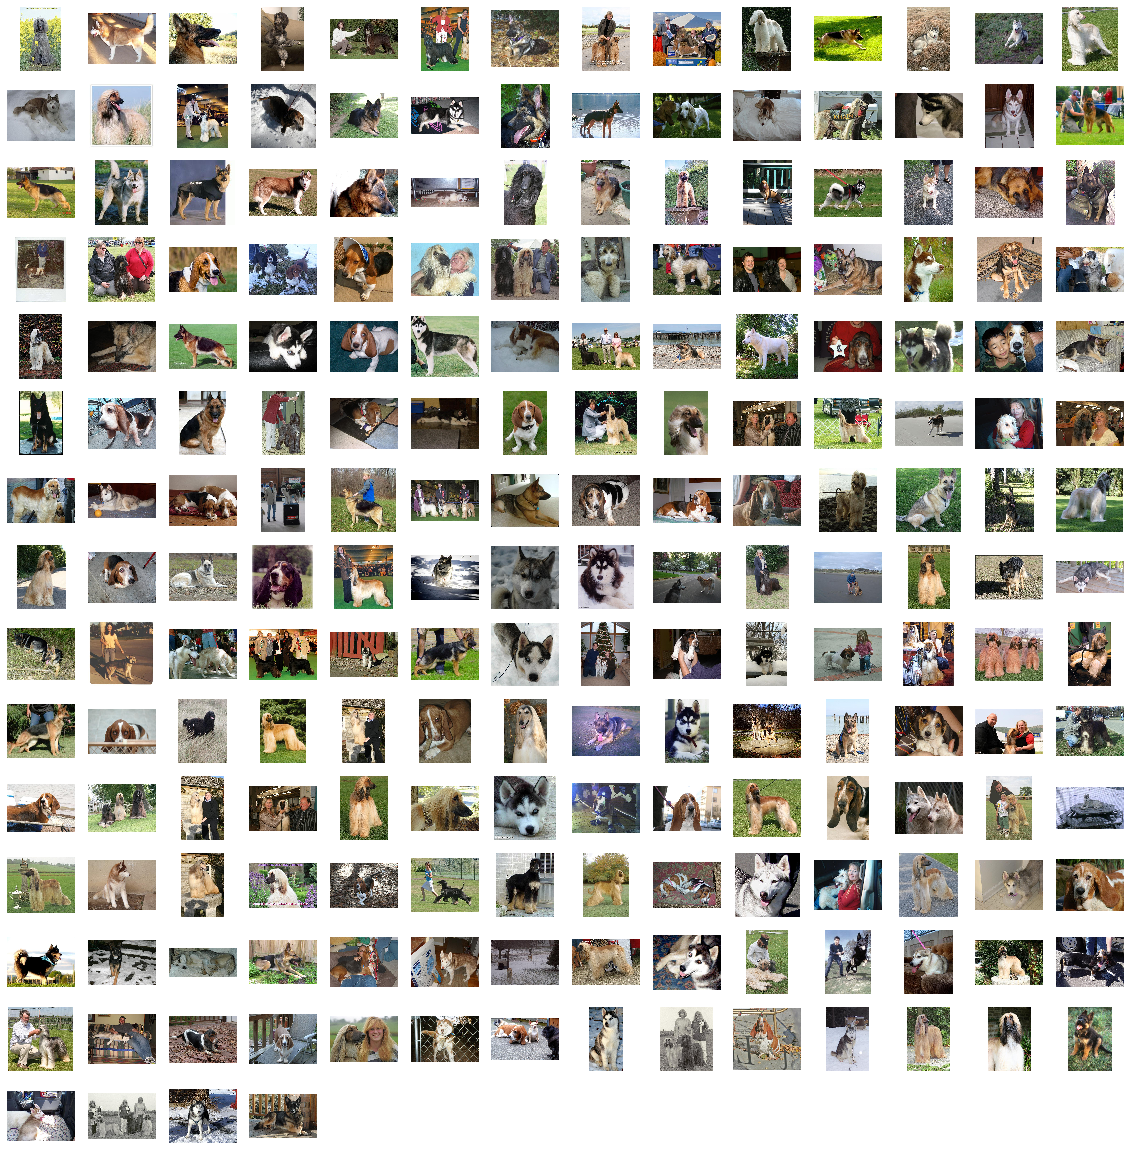

In [10]:
plotfromdir("images/", myimgs)

sample 0 to score


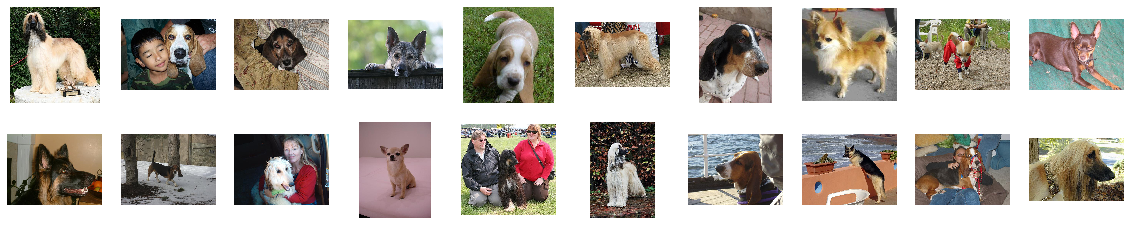

KeyboardInterrupt: 

In [39]:
jdx = 0
while jdx < ns:
    print("sample", jdx, "to score")
    
    w_mediate = w_vec
    
    ## Get a random summary
    SummarySet = np.random.choice(range(nn), kk, replace=False)
    plotfromdir("images/", myimgs[SummarySet], compact=True); plt.show()
    x = np.log(1 + gamma*np.sum(mydata[SummarySet,:], axis=0))
    x = np.expand_dims(x, 1) ## mm x 1
    
    y = input()
    y = float(y)
    
    ## Learn
    Cinv += 1.0/noise_sq * (x @ x.transpose()) ## mm x mm
    Yvec += (1.0/noise_sq) * y * x ## mm x 1
    w_vec = np.squeeze(np.dot(np.linalg.inv(Cinv), Yvec)) ## mm

    if zerothresh_flag == 1:
        w_vec[w_vec<0] = 0
    
    if jdx % monitor_freq == 0:
        print("monitoring ...")
        GreedySet, _ = subm.greedygains_submod(V, mydata, w_vec, kk)
        plotfromdir("images/", myimgs[GreedySet], compact=True)
        print("is the current greedy solution")
    
    jdx += 1


is the current greedy solution


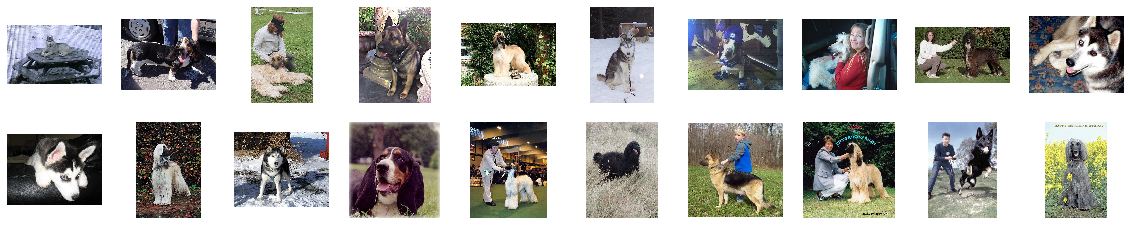

In [22]:
GreedySet, _ = subm.greedygains_submod(V, mydata, w_vec, kk)
plotfromdir("images/", myimgs[GreedySet], compact=True)
print("is the current greedy solution")

In [23]:
w_vec

array([0.        , 0.00826485, 0.00249856, 0.01170051, 0.0041034 ,
       0.00020496, 0.00106475, 0.00552626, 0.        , 0.00705518,
       0.01046048, 0.        , 0.00670965, 0.0028071 , 0.        ,
       0.00640276, 0.00202814, 0.00405204, 0.        , 0.00204127])

In [24]:
mycats[GreedySet]

array([100,  11,  10,  85,  10, 100,  11,  10,  10, 100, 100,  10, 100,
        11,  10,  10,  85,  10,  85,  10])

In [37]:
np.bincount(mycats)

array([33, 46, 43, 33, 45])